<a href="https://colab.research.google.com/github/JHyunjun/SuperResolution/blob/main/231014.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [162]:
# Created By unknown-user(Hyundai CTO Dacon)
# From 23.10.14

In [193]:
# Importing

import tensorflow as tf
import os
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Lambda, Input, Add, Dense, Reshape, Flatten, UpSampling2D, Conv2D, LeakyReLU, BatchNormalization, Activation,Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import scipy.ndimage as ndimage
from scipy.ndimage import median_filter, uniform_filter
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random
import cv2


In [164]:
# Salt and pepper Denoising

def selective_median_filter(img, kernel_size=3, threshold1 = 0, threshold2 = 1):
    # Masks where the image has values close to 0 or 1
    mask_salt = img > (1.0 - threshold1) # white
    mask_pepper = img < threshold2 # black
    mask_combined = tf.math.logical_or(mask_salt, mask_pepper).numpy()

    # Convert image to numpy for processing
    img_numpy = img.numpy()

    # Apply median filter only where the mask is true
    for i in range(img_numpy.shape[2]):  # For each channel
        channel = img_numpy[:,:,i]
        channel_filtered = median_filter(channel, size=kernel_size)
        #channel_filtered = uniform_filter(channel, size=kernel_size)
        # Replace only the noisy pixels
        channel[mask_combined[:,:,0]] = channel_filtered[mask_combined[:,:,0]]
        img_numpy[:,:,i] = channel

    return tf.convert_to_tensor(img_numpy, dtype=tf.float32)

In [165]:
# Data
directory_path_train_lr = "/content/drive/MyDrive/Colab_Notebooks/Hyundai_Daycon/train_lr"
directory_path_train_hr = "/content/drive/MyDrive/Colab_Notebooks/Hyundai_Daycon/train_hr"

batch_size = 32
image_slicing = 3000

lr_image_files = sorted([os.path.join(directory_path_train_lr, f) for f in os.listdir(directory_path_train_lr)])
hr_image_files = sorted([os.path.join(directory_path_train_hr, f) for f in os.listdir(directory_path_train_hr)])

lr_image_files_3000 = lr_image_files[:image_slicing]
hr_image_files_3000 = hr_image_files[:image_slicing]

# pre-processing
def load_images(lr_path, hr_path):
    lr = tf.io.read_file(lr_path)
    lr = tf.image.decode_jpeg(lr, channels=3)
    lr = tf.image.resize(lr, [256, 256])
    lr = lr / 255.0
    lr_filter = tf.py_function(func=selective_median_filter, inp=[lr], Tout=tf.float32)

    hr = tf.io.read_file(hr_path)
    hr = tf.image.decode_jpeg(hr, channels=3)
    hr = tf.image.resize(hr, [1024, 1024])
    hr = hr / 255.0

    return lr_filter, hr
    #return lr, hr, lr_filter

train_dataset = tf.data.Dataset.from_tensor_slices((lr_image_files_3000, hr_image_files_3000))
train_dataset = train_dataset.map(load_images)
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


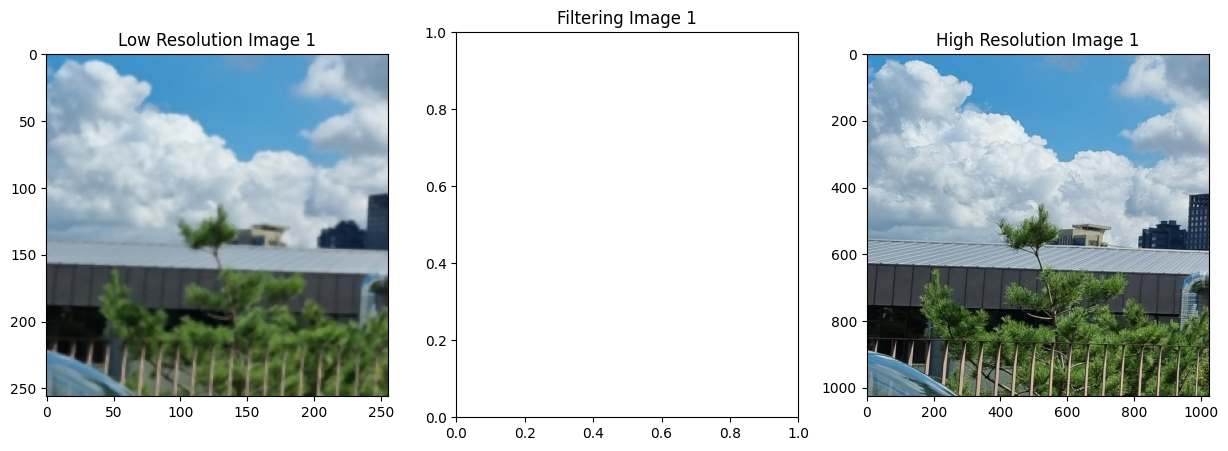

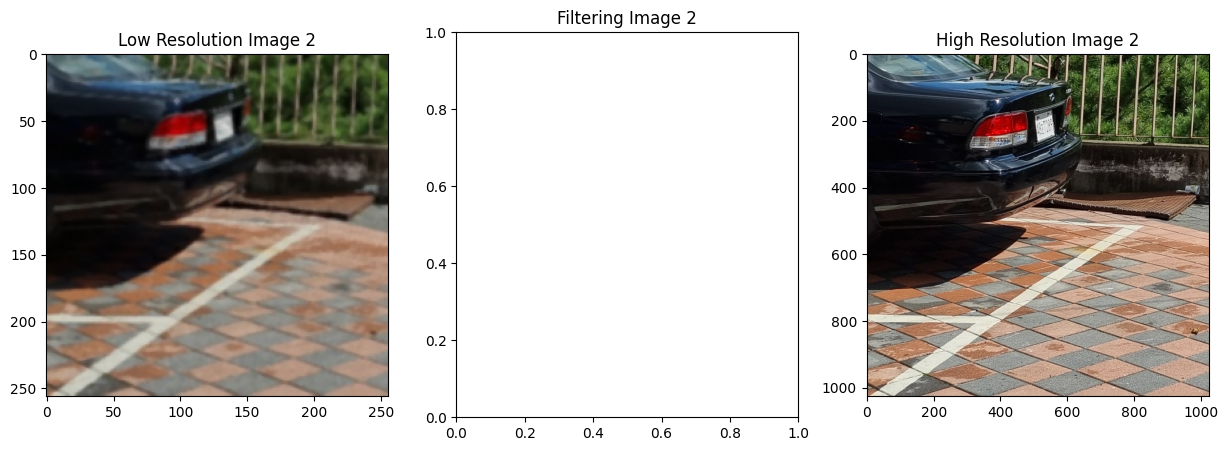

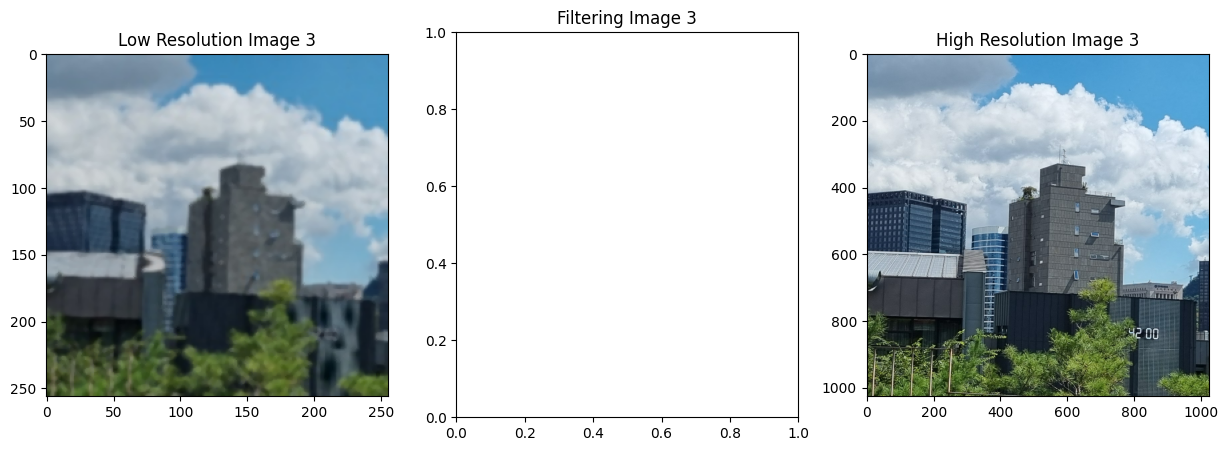

In [166]:
def show_images(dataset, num_samples=3):
    #for i, (lr_image, hr_image, lr_filter) in enumerate(dataset.unbatch().take(num_samples)):
    for i, (lr_image, hr_image) in enumerate(dataset.unbatch().take(num_samples)):
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(lr_image.numpy())
        plt.title(f"Low Resolution Image {i+1}")

        plt.subplot(1, 3, 2)
        #plt.imshow(lr_filter.numpy())
        plt.title(f"Filtering Image {i+1}")

        plt.subplot(1, 3, 3)
        plt.imshow(hr_image.numpy())
        plt.title(f"High Resolution Image {i+1}")

        plt.show()

show_images(train_dataset)

In [167]:
#Super Resolution

def residual_block(x, filters, kernel_size=3, scaling=0.1):
    tmp = Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    tmp = Conv2D(filters, kernel_size, padding='same')(tmp)
    tmp = Add()([x, tmp])
    return tmp

def upsample(x, scale=4):
    return Lambda(lambda x: tf.nn.depth_to_space(x, scale))(x)

def EDSR(input_shape=(256,256,3), scale=4):
    inputs = Input(input_shape)

    x = Conv2D(64, 9, padding='same', activation='relu')(inputs)
    for _ in range(5):  # Number of residual blocks
        x = residual_block(x, 64)

    x = Conv2D(64, 3, padding='same')(x)
    x = upsample(x, scale)
    outputs = Conv2D(3, 9, padding='same')(x)

    return Model(inputs, outputs)

model = EDSR()
model.compile(optimizer='adam', loss='mse')
model.summary()

model.fit(train_dataset, epochs=20)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_78 (Conv2D)          (None, 256, 256, 64)         15616     ['input_7[0][0]']             
                                                                                                  
 conv2d_79 (Conv2D)          (None, 256, 256, 64)         36928     ['conv2d_78[0][0]']           
                                                                                                  
 conv2d_80 (Conv2D)          (None, 256, 256, 64)         36928     ['conv2d_79[0][0]']           
                                                                                            

1/1 [==============================] - 0s 182ms/step


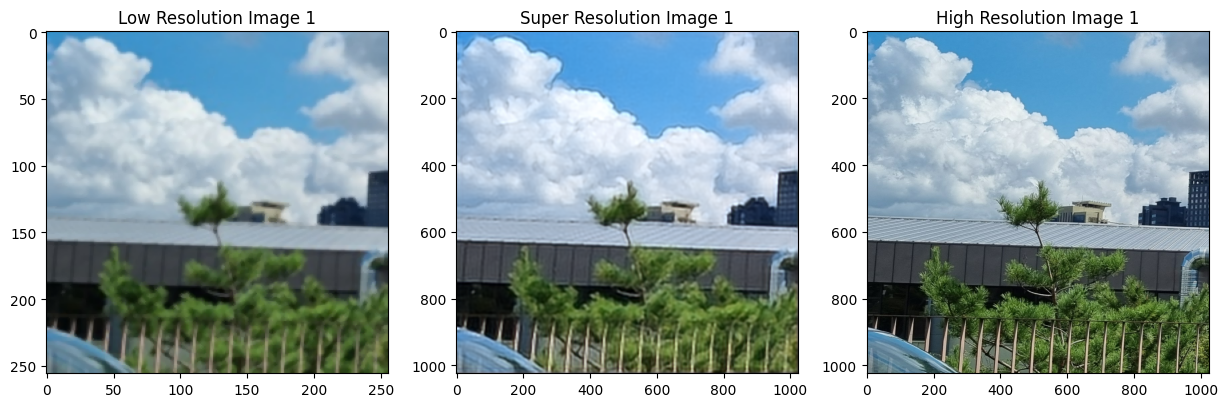

1/1 [==============================] - 0s 130ms/step


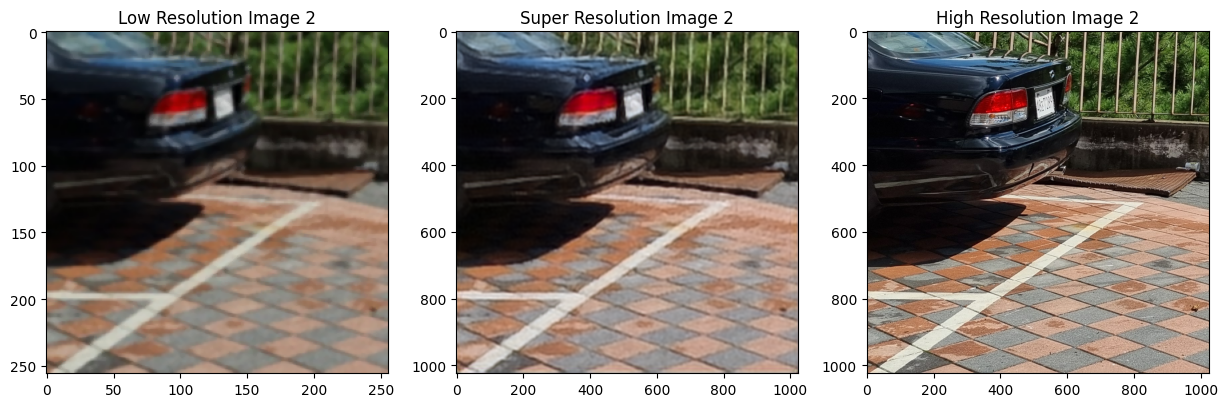

1/1 [==============================] - 0s 87ms/step


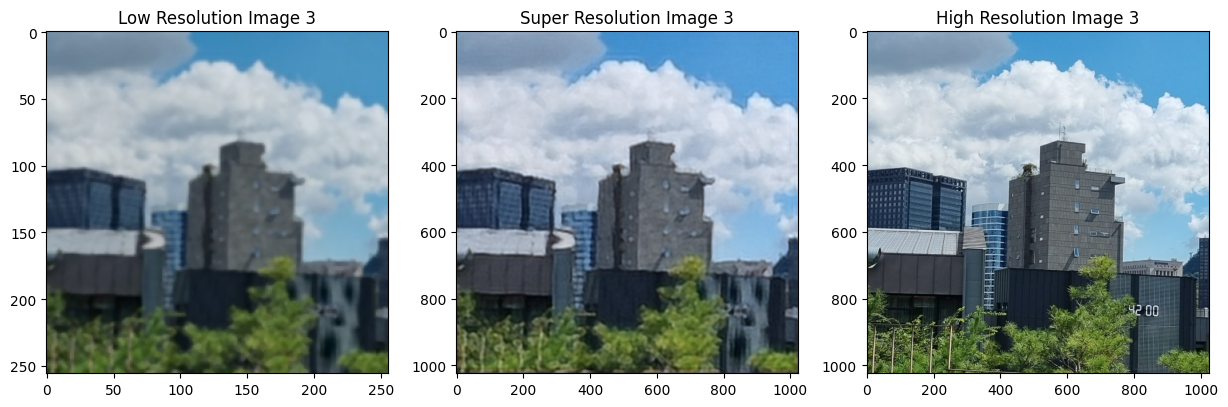

In [169]:
def show_images(dataset, num_samples=3):
    #for i, (lr_image, hr_image, lr_filter) in enumerate(dataset.unbatch().take(num_samples)):
    for i, (lr_image, hr_image) in enumerate(dataset.unbatch().take(num_samples)):
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(lr_image.numpy())
        plt.title(f"Low Resolution Image {i+1}")

        lr_image = tf.expand_dims(lr_image, 0)
        sr = model.predict(lr_image)
        sr = np.clip(sr, 0, 1)
        plt.subplot(1, 3, 2)
        plt.imshow(tf.squeeze(sr))
        plt.title(f"Super Resolution Image {i+1}")

        plt.subplot(1, 3, 3)
        plt.imshow(hr_image.numpy())
        plt.title(f"High Resolution Image {i+1}")

        plt.show()

show_images(train_dataset)

1/1 [==============================] - 0s 20ms/step


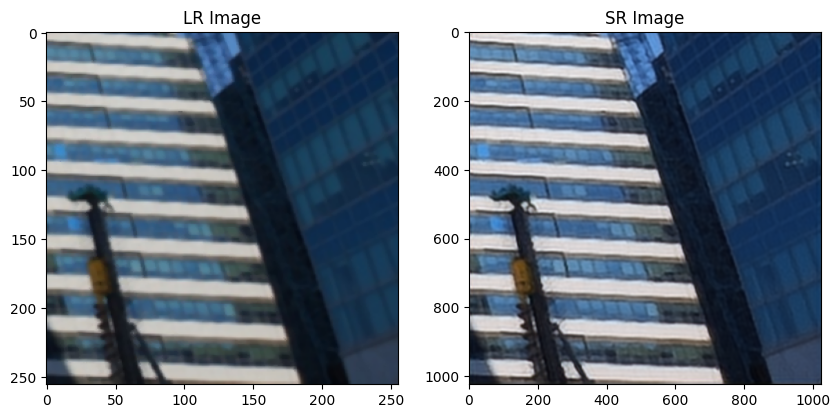

1/1 [==============================] - 0s 26ms/step


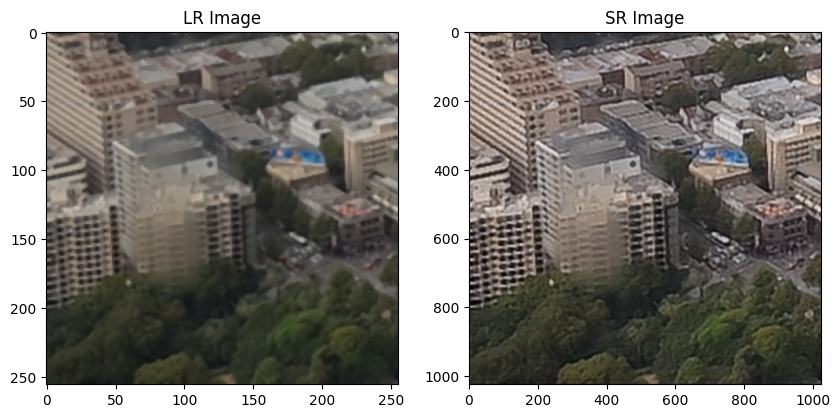

1/1 [==============================] - 0s 32ms/step


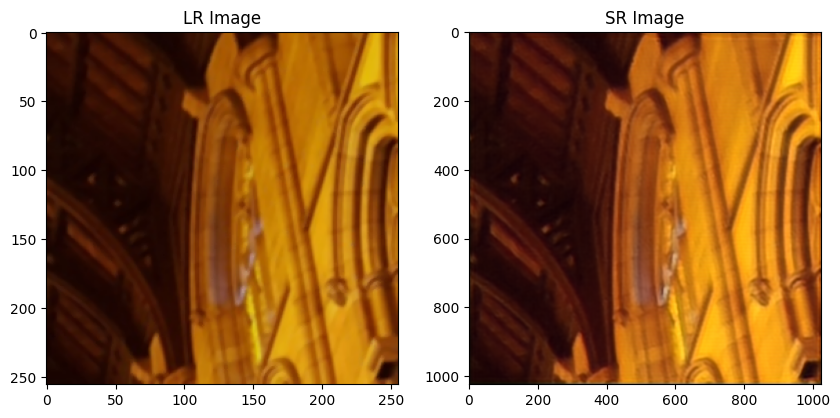

1/1 [==============================] - 0s 42ms/step


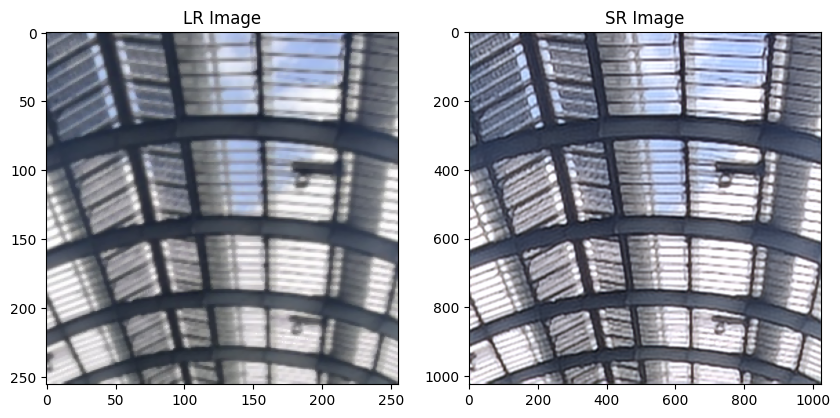

1/1 [==============================] - 0s 46ms/step


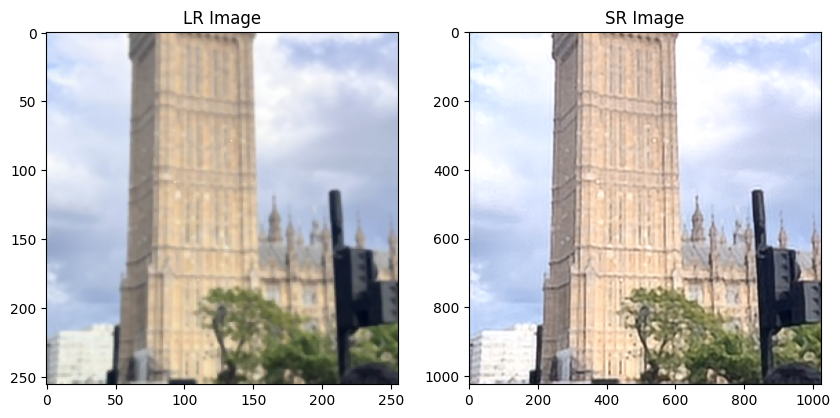

1/1 [==============================] - 0s 43ms/step


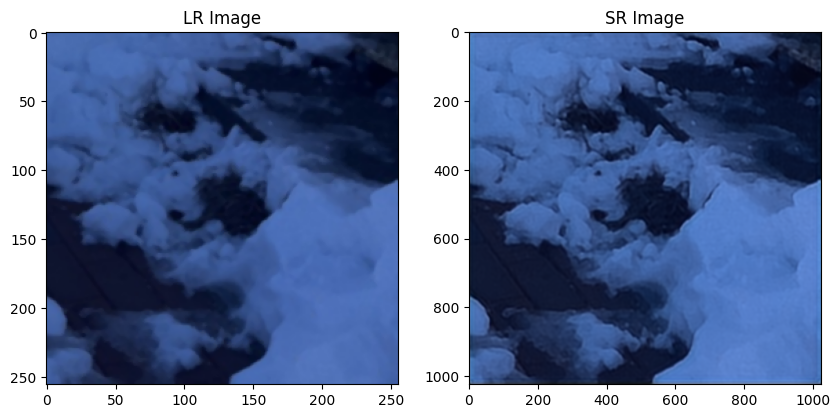

1/1 [==============================] - 0s 42ms/step


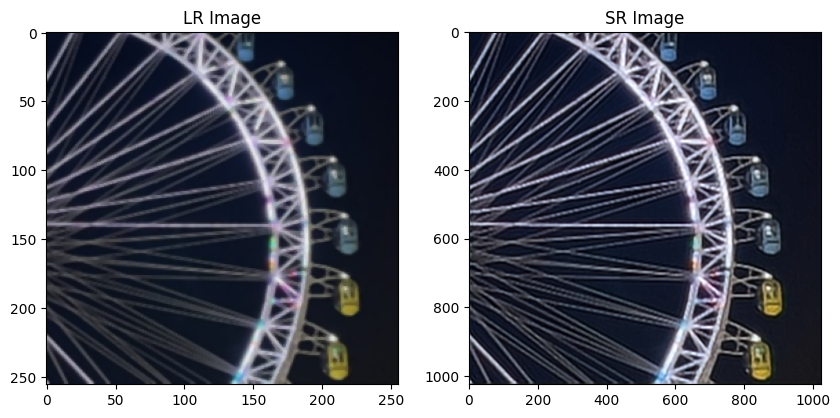

1/1 [==============================] - 0s 33ms/step


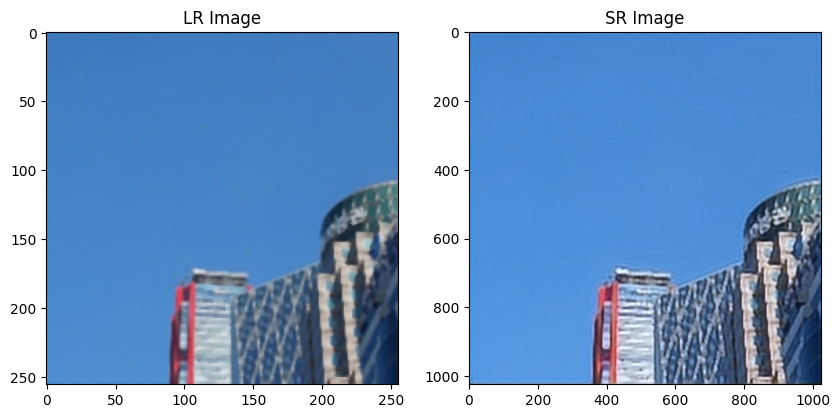

1/1 [==============================] - 0s 37ms/step


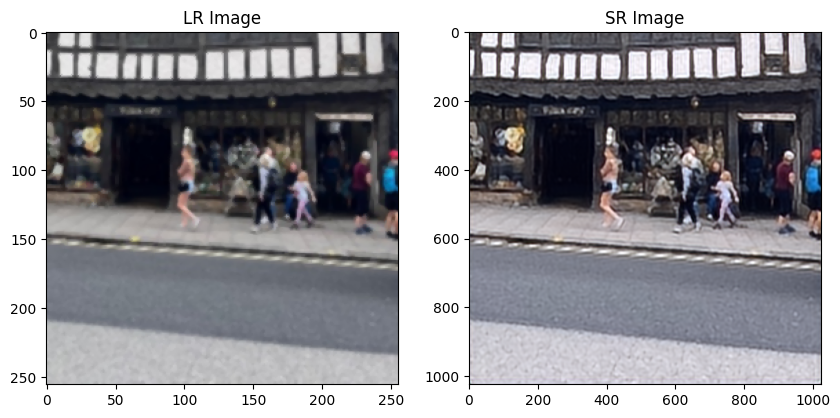

1/1 [==============================] - 0s 46ms/step


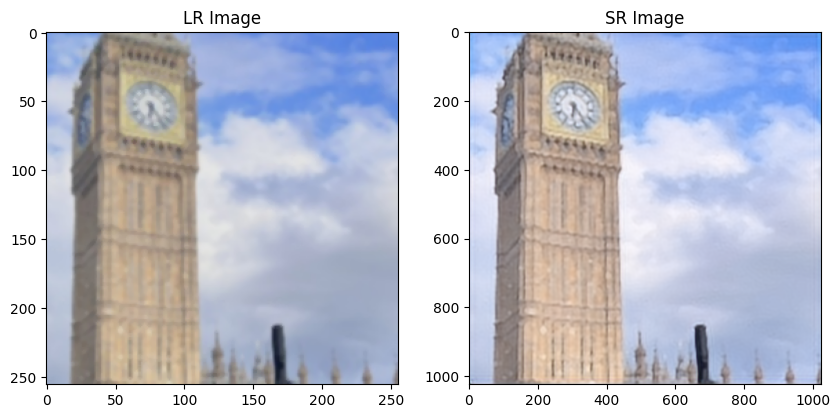

In [197]:
# Testifying

directory_path_test_lr = "/content/drive/MyDrive/Colab_Notebooks/Hyundai_Daycon/test/lr"
test_image_files = sorted([os.path.join(directory_path_test_lr, fname) for fname in os.listdir(directory_path_test_lr) if fname.endswith('.png') or fname.endswith('.jpg')])

def load_and_preprocess_image(img_path):
    img = load_img(img_path, target_size=(256, 256))
    img = img_to_array(img)
    img = img / 255.0
    img_filter = tf.py_function(func=selective_median_filter, inp=[img], Tout=tf.float32)
    return img_filter

selected_test_image_files = random.sample(test_image_files, 10)

for test_img_path in selected_test_image_files:
    test_img = load_and_preprocess_image(test_img_path)
    test_img_input = tf.expand_dims(test_img, 0)

    sr_img = model.predict(test_img_input)
    sr_img = tf.squeeze(sr_img)
    sr_img = np.clip(sr_img, 0, 1)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(test_img)
    plt.title("LR Image")

    plt.subplot(1, 2, 2)
    plt.imshow(sr_img)
    plt.title("SR Image")

    plt.show()

In [198]:
# Data saving for submission

directory_path_test_lr = "/content/drive/MyDrive/Colab_Notebooks/Hyundai_Daycon/test/lr"
test_image_files = [os.path.join(directory_path_test_lr, fname) for fname in os.listdir(directory_path_test_lr) if fname.endswith('.png') or fname.endswith('.jpg')]

def load_and_preprocess_image(img_path):
    img = load_img(img_path, target_size=(256, 256))
    img = img_to_array(img)
    img = img / 255.0
    img_filter = tf.py_function(func=selective_median_filter, inp=[img], Tout=tf.float32)
    return img_filter

save_directory = "/content/drive/MyDrive/Colab_Notebooks/Hyundai_Daycon/test_hr/231014_1_a"

for test_img_path in test_image_files:
    test_img = load_and_preprocess_image(test_img_path)
    test_img_input = tf.expand_dims(test_img, 0)

    sr_img = model.predict(test_img_input)
    sr_img = tf.squeeze(sr_img).numpy()
    sr_img = np.clip(sr_img * 255, 0, 255).astype(np.uint8)  #De-normalizing
    # RGB to BGR
    sr_img_bgr = cv2.cvtColor(sr_img, cv2.COLOR_RGB2BGR)

    # Use the same filename from input
    filename = os.path.join(save_directory, os.path.basename(test_img_path))

    cv2.imwrite(filename, sr_img_bgr)


1/1 [==============================] - 0s 21ms/step
